# IMPORTS

In [44]:
import yaml
import firebase_admin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import json

from math import sin, cos, sqrt, atan2, radians


from firebase_admin import credentials
from firebase_admin import firestore

# CONNECT TO FIREBASE

In [2]:
filename='/Users/5danalfaro/OAN/credentials/firebase_parameters.json'

In [3]:
# Use a service account
cred = credentials.Certificate(filename)
firebase_admin.initialize_app(cred)

db = firestore.client()

# GET VILLAGE AND PRIORITY SURVEYS

In [4]:
col_query = db.collection('Surveys').document('Backup').collection('Answers').where(u'survey_type', u'==', u'2-survey_priority')


In [5]:
col_sur_priority = col_query.stream()

In [6]:
l_sur_priority = []
for doc in col_sur_priority:
    l_sur_priority.append(doc.to_dict())

In [7]:
len(l_sur_priority)

85

In [8]:
col_query = (db.collection('Surveys').
                    document('Backup').
                        collection('Answers').
                            where(u'survey_type', u'==', u'1-survey_village')
            )

In [9]:
col_sur_village = col_query.stream()

In [10]:
l_sur_village = []
for doc in col_sur_village:
    l_sur_village.append(doc.to_dict())

In [11]:
len(l_sur_village)

7

In [12]:
[vil['data']['village_name'] for vil in l_sur_village]

['Kora seko Kparou où Sansi Gah Gourou',
 'Tata Lafiarou ou Djonwouro Kparou ',
 'Debbo',
 'Gbérou kpanin',
 'Wodora',
 'Alafiarou',
 'Tata Lafiarou ou Djonwouro Kparou ']

In [13]:
[vil['data']['village_pop'] for vil in l_sur_village]

['null', '80', '120', '150', '70', '400', '80']

# PROCESS DATA

## PRIORISATION DATA

In [14]:
df_priority=pd.DataFrame([{'latitude':doc['coords']['latitude'],
  'longitude':doc['coords']['longitude'],
  'creation_date':doc['creation_date'],
  'nb_basin':doc['data']['nb_basin'],
  'nb_people':doc['data']['nb_people'],
  'nb_diarrhoea':doc['data']['nb_diarrhoea'],
  'nb_malnu':doc['data']['nb_malnu'],
  'water_storage':doc['data']['water_storage'],
  'water_quality':doc['data']['water_quality'],
  'self_manag':doc['data']['self_manag']
  
    } for doc in l_sur_priority
])

## Village data

In [15]:
df_village=pd.DataFrame(
    [{'latitude':doc['coords']['latitude'],
      'longitude':doc['coords']['longitude'],
      'village_coords':doc['data']['village_coords'],
      'creation_date':doc['creation_date'],
      'nb_water_sources':doc['data']['nb_water_sources'],
      'heath_center':doc['data']['heath_center'],
      'village_pop':doc['data']['village_pop'],
      'village_name':doc['data']['village_name'],
      'water_sources':doc['data']['water_sources']

        } for doc in l_sur_village
    ]
)

In [16]:
df_village['longitude']=df_village.apply(lambda x: x['village_coords'].split(' ;')[1],axis=1)

In [17]:
df_village['latitude']=df_village.apply(lambda x: x['village_coords'].split(' ;')[0],axis=1)

In [18]:
l_s_potable= ['PPM','AEV','FPM']

In [19]:
df_village['%_s_potable']=df_village.apply(
    lambda x: 100*(len([source['ws_type'] 
                   for source in x['water_sources'] if source['ws_type'] in l_s_potable])
                /float(x['nb_water_sources']))
    ,axis=1
)

### merge village and priority

In [29]:
'''get village from minimum distance to survey (and date of creation date)'''
def get_village(x):
    min_dist=1
    village=''
    prior_cre_date=x['creation_date']
    lat=float(x['latitude'])
    lon=float(x['longitude'])
    for vil_coords,vil_name in zip(df_village['village_coords'].to_list(),
                                   df_village['village_name'].to_list()
                                  ):
        vil_lat = float(vil_coords.split(' ;')[0])
        vil_lon = float(vil_coords.split(' ;')[1])
        
        distance=((vil_lat-lat)**2+(vil_lon-lon)**2)**0.5
        if min_dist > distance:
            min_dist=distance
            village=vil_name
    #print(prior_cre_date[5:10],
    #      df_village[df_village['village_name']==vil_name]['creation_date'].values[0][5:10],
    #     prior_cre_date[5:10]==df_village[df_village['village_name']==vil_name]['creation_date'].values[0][5:10],
    #     village)
    #        
    return village
        

In [52]:
df_priority['nb_people'] = pd.to_numeric(df_priority['nb_people'],errors='coerce')
df_priority['nb_diarrhoea'] = pd.to_numeric(df_priority['nb_diarrhoea'],errors='coerce')
df_priority['nb_malnu'] = pd.to_numeric(df_priority['nb_malnu'],errors='coerce')
df_priority['nb_basin'] = pd.to_numeric(df_priority['nb_basin'],errors='coerce')
df_priority['water_quality'] = pd.to_numeric(df_priority['water_quality'],errors='coerce')
df_priority['self_manag'] = pd.to_numeric(df_priority['self_manag'],errors='coerce')
df_priority['latitude'] = pd.to_numeric(df_priority['latitude'],errors='coerce')
df_priority['longitude'] = pd.to_numeric(df_priority['longitude'],errors='coerce')

In [22]:
df_priority['l/per']=df_priority['nb_basin']*25/df_priority['nb_people']

In [23]:
df_priority['t_diar']=df_priority['nb_diarrhoea']*100/df_priority['nb_people']

In [24]:
df_priority['t_mal']=df_priority['nb_malnu']*100/df_priority['nb_people']

In [30]:
df_priority['village']=df_priority.apply(lambda x: get_village(x),axis=1)

In [31]:
df_priority

,latitude,longitude,creation_date,nb_basin,nb_people,nb_diarrhoea,nb_malnu,water_storage,water_quality,self_manag,l/per,t_diar,t_mal,village
0,9.9138,3.40457,2019-11-01T08:11:00.456Z,7,4,1,1,NO,4.0,4,43.750000,25.000000,25.000000,Alafiarou
1,9.90037,3.40495,2019-10-30T15:56:30.815Z,8,17,3,0,NO,1.0,4,11.764706,17.647059,0.000000,Alafiarou
2,9.9145,3.40468,2019-11-01T08:18:44.907Z,9,14,3,0,NO,2.0,4,16.071429,21.428571,0.000000,Alafiarou
3,9.90121,3.40528,2019-10-30T16:21:04.159Z,13,10,1,0,NO,2.0,4,32.500000,10.000000,0.000000,Alafiarou
4,9.93477,3.41619,2019-10-29T15:54:25.058Z,6,9,0,0,NO,4.0,5,16.666667,0.000000,0.000000,Kora seko Kparou où Sansi Gah Gourou
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,9.93279,3.41592,2019-10-29T13:36:27.742Z,99,83,3,2,NO,4.0,5,29.819277,3.614458,2.409639,Kora seko Kparou où Sansi Gah Gourou
81,9.86297,3.28377,2019-11-02T12:40:57.354Z,19,15,4,0,NO,2.0,4,31.666667,26.666667,0.000000,Debbo
82,9.8864,3.26168,2019-11-02T10:43:10.355Z,14,12,3,0,NO,2.0,4,29.166667,25.000000,0.000000,Debbo
83,9.87848,3.27046,2019-11-02T11:21:20.038Z,20,10,1,0,NO,2.0,4,50.000000,10.000000,0.000000,Debbo


In [32]:
df_priority.groupby('village').agg({
                                    'nb_people':'sum',
                                    'l/per':'mean',
                                    'nb_diarrhoea':'sum',
                                    'nb_malnu':'sum',
                                    'nb_basin':'sum',
                                    'water_quality':'mean',
                                    'self_manag':'mean',
                                    't_diar':'mean',
                                    't_mal':'mean',
                                    'creation_date':'count'
                            })

,nb_people,l/per,nb_diarrhoea,nb_malnu,nb_basin,water_quality,self_manag,t_diar,t_mal,creation_date
village,,,,,,,,,,
Alafiarou,678,24.630128,138,6,567,1.961538,4.055556,21.758433,1.320547,54
Debbo,227,34.620251,40,3,262,2.066667,4.066667,17.045342,0.702160,15
Kora seko Kparou où Sansi Gah Gourou,194,27.930525,20,2,218,3.666667,4.777778,12.247193,0.267738,9
Tata Lafiarou ou Djonwouro Kparou,77,25.696261,18,1,64,1.857143,4.000000,28.829583,2.380952,7


In [33]:
df_vill_analy=df_priority.groupby('village').agg({
                                    'nb_people':'sum',
                                    'nb_diarrhoea':'sum',
                                    'nb_malnu':'sum',
                                    'nb_basin':'sum',
                                    'water_quality':'mean',
                                    'self_manag':'mean',
                                    'creation_date':'count'
                            }).reset_index()

In [34]:
df_vill_analy['l/per']=df_vill_analy['nb_basin']*25/df_vill_analy['nb_people']

In [35]:
df_vill_analy['t_diar']=df_vill_analy['nb_diarrhoea']*100/df_vill_analy['nb_people']

In [36]:
df_vill_analy['t_mal']=df_vill_analy['nb_malnu']*100/df_vill_analy['nb_people']

In [37]:
col_name=list(df_vill_analy.columns)
col_name[7]='n_enquetes'
df_vill_analy.columns=col_name

In [38]:
df_vill_analy

,village,nb_people,nb_diarrhoea,nb_malnu,nb_basin,water_quality,self_manag,n_enquetes,l/per,t_diar,t_mal
0,Alafiarou,678,138,6,567,1.961538,4.055556,54,20.907080,20.353982,0.884956
1,Debbo,227,40,3,262,2.066667,4.066667,15,28.854626,17.621145,1.321586
2,Kora seko Kparou où Sansi Gah Gourou,194,20,2,218,3.666667,4.777778,9,28.092784,10.309278,1.030928
3,Tata Lafiarou ou Djonwouro Kparou,77,18,1,64,1.857143,4.000000,7,20.779221,23.376623,1.298701


In [137]:
df_village.loc[4,'water_sources']

[{'ws_coords': '9.9056017 ; 3.4013483',
  'ws_coms': 'null',
  'ws_type': 'null',
  'ws_operative': 'YES'},
 {'ws_operative': 'YES',
  'ws_coords': '9.9053433 ; 3.4040567',
  'ws_coms': 'Se gâte souvent ',
  'ws_type': 'PPM'}]

## CONTAR CASAS DESDE OPENSTREETMAPS

In [82]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = ("""
[out:json];
area['name'='"""+str('Alafiarou').upper()+
"""']->.a;
way[building](area.a);
(._;>;);
out body;
""")
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

In [83]:
houses = []
ways=[elem for elem in data['elements']  if elem['type']=='way']
nodes=[elem for elem in data['elements']  if elem['type']=='node']
for way in ways:
    houses_info={}
    houses_info['id']=way['id']
    nodes_lats=[]
    nodes_longs=[]
    houses_info['nodes']=way['nodes']
    for node in nodes:
        if node['id'] in houses_info['nodes']:
            nodes_lats.append(node['lat'])
            nodes_longs.append(node['lon'])
    houses_info['lat']=np.mean(np.array(nodes_lats))
    houses_info['lon']=np.mean(np.array(nodes_longs))
    houses.append(houses_info)

In [84]:
df_houses=pd.DataFrame(houses)

In [85]:
len(df_houses)

114

In [86]:
def distance(p_1,p_2):
    # approximate radius of earth in m
    R = 6373000

    lat1 = radians(p_1['lat'])
    lon1 = radians(p_1['lon'])
    lat2 = radians(p_2['lat'])
    lon2 = radians(p_2['lon'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [87]:
def has_been_survey(x):
    p_1={'lat':float(x['lat']),'lon':float(x['lon'])}
    points=df_priority.apply(lambda x: True
                             if distance(p_1,{'lat':x['latitude'],'lon':x['longitude']}) <20
                             else False
                                        ,axis=1)
    return points.any()

In [88]:
df_houses['surveyed']=df_houses.apply(lambda x: has_been_survey(x),axis=1)

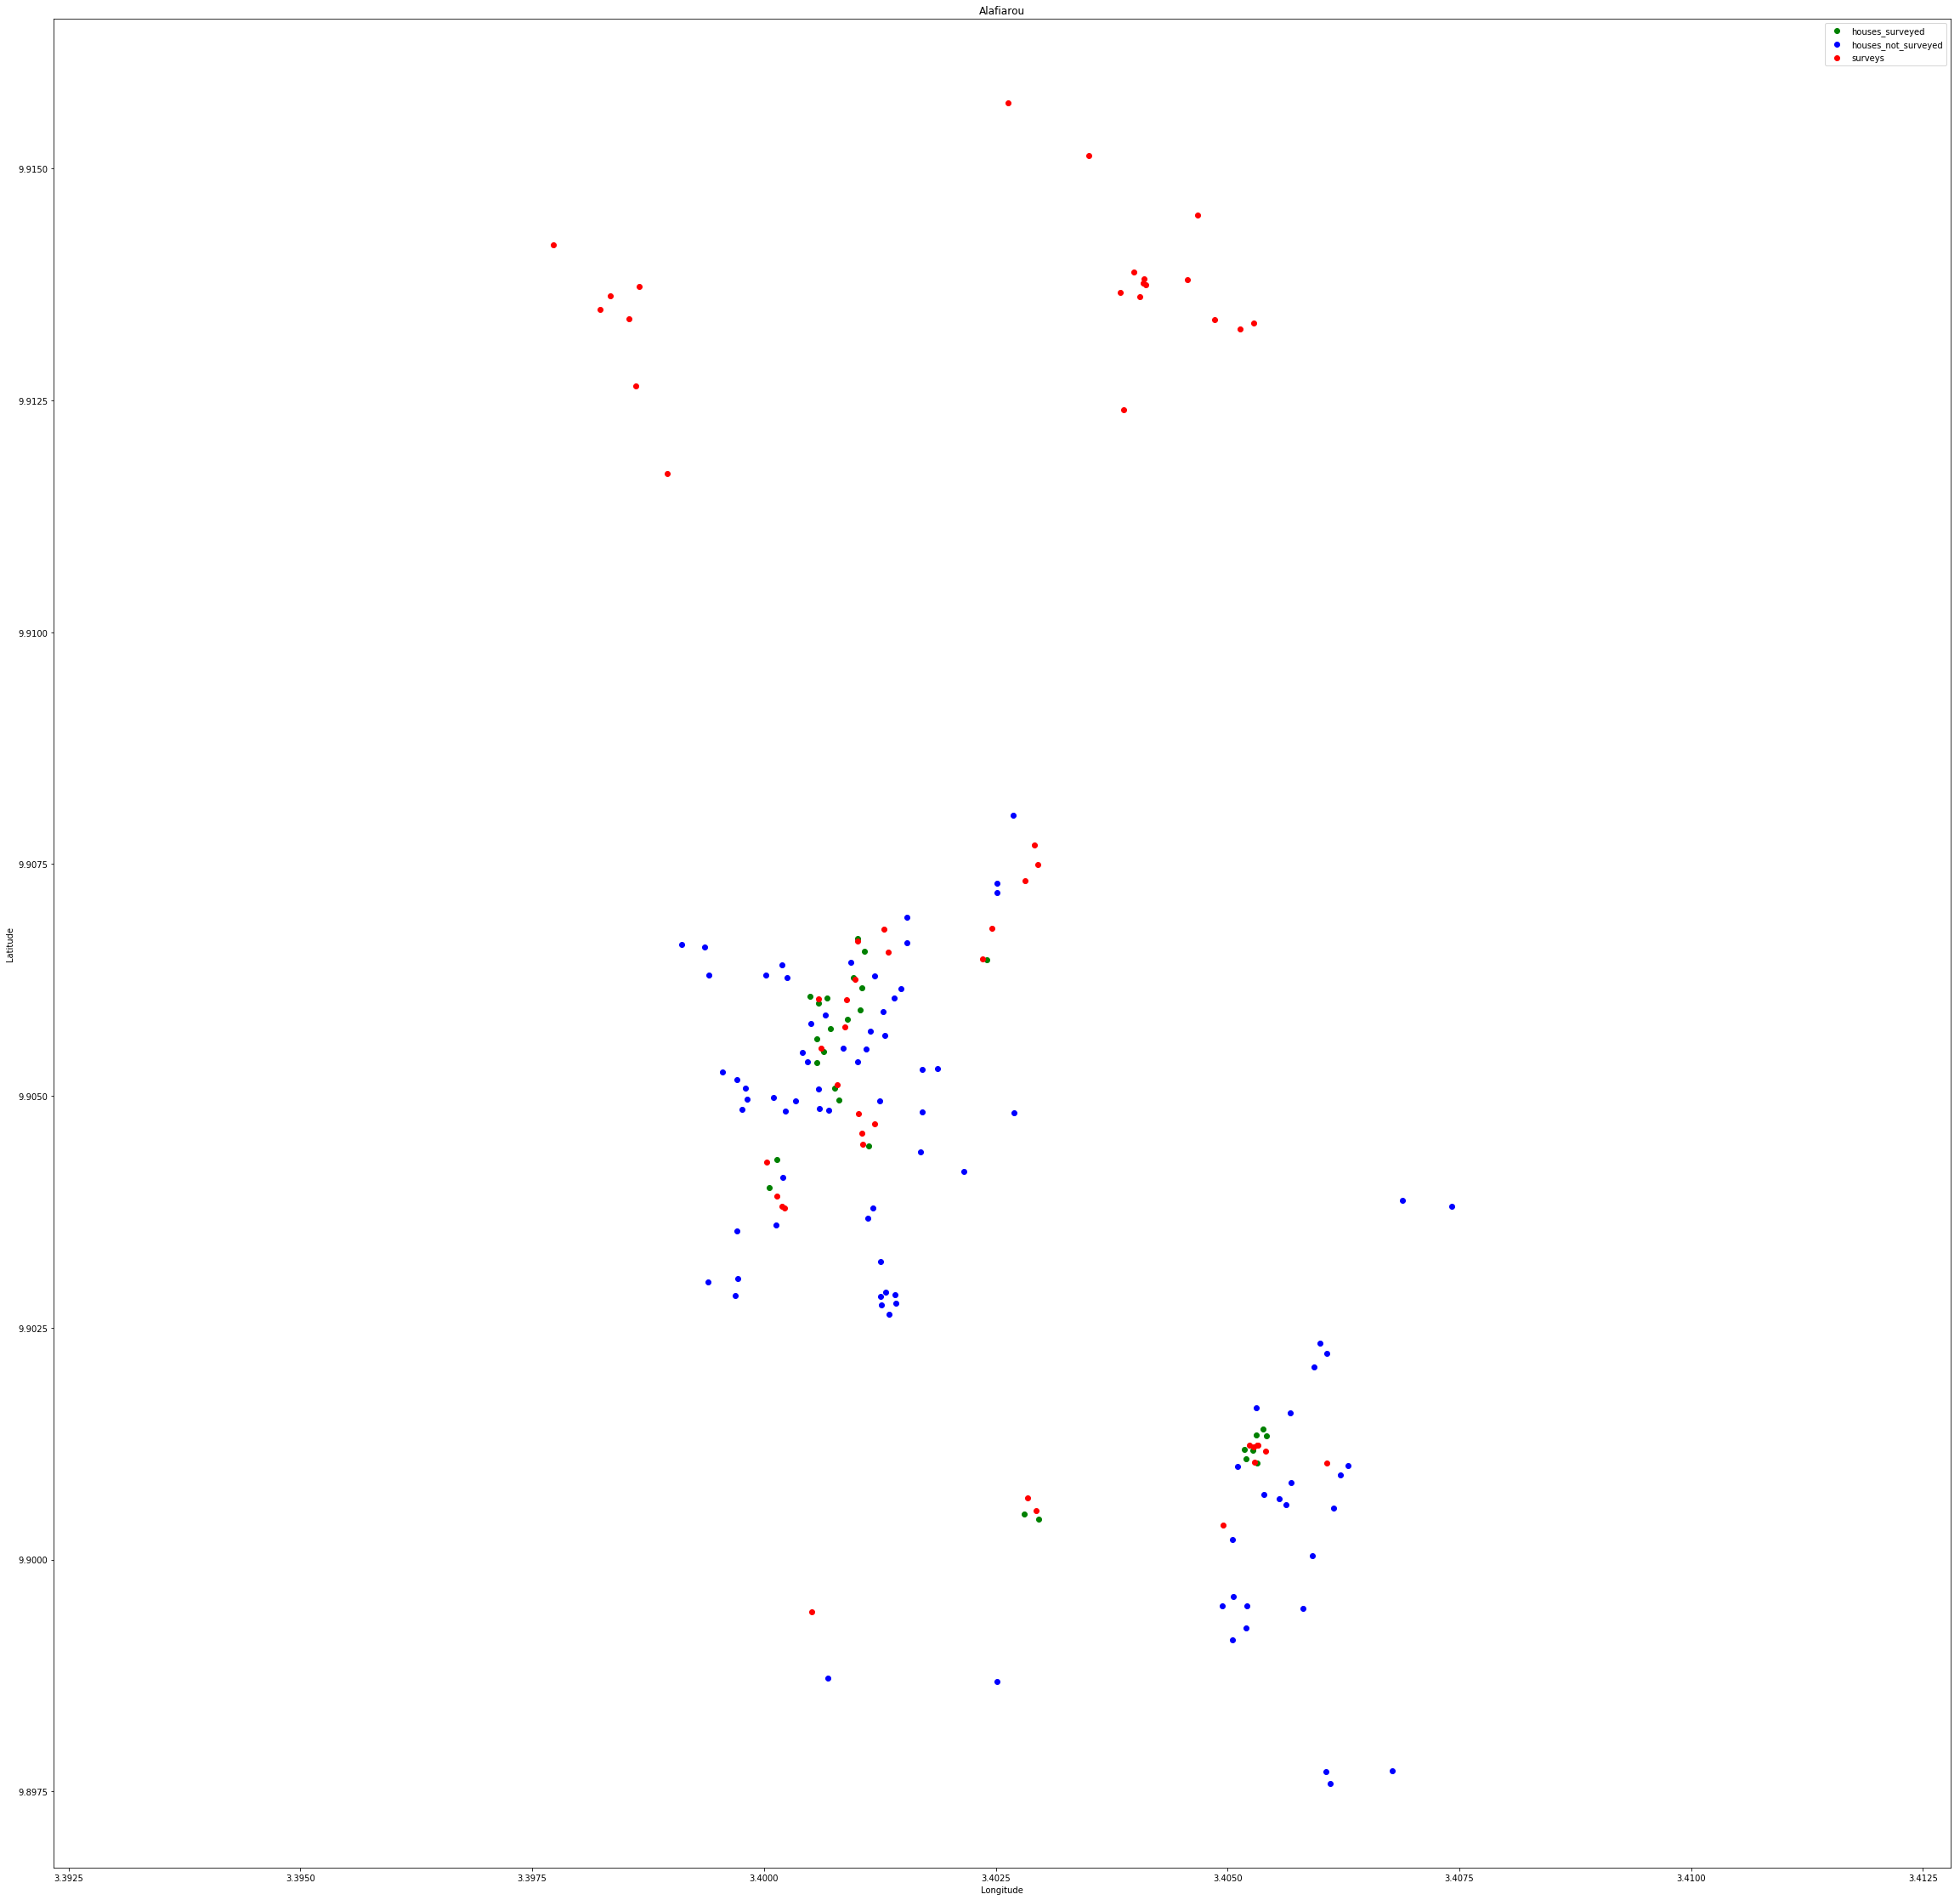

In [92]:
village='Alafiarou'
f,ax = plt.subplots(1,figsize=(40,40))
# Collect coords into list
coords = []

df_survey=df_houses[df_houses['surveyed']]
for a,b in zip(df_survey['lon'].to_list(),df_survey['lat'].to_list()):
        coords.append((a, b))
# Convert coordinates into numpy array
X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='green',label='houses_surveyed')

coords = []
df_notsurvey=df_houses[~df_houses['surveyed']]
for a,b in zip(df_notsurvey['lon'].to_list(),df_notsurvey['lat'].to_list()):
        coords.append((a, b))
# Convert coordinates into numpy array
X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='blue',label='houses_not_surveyed')

coords = []
df_debbo=df_priority[df_priority['village']==village]
for a,b in zip(df_debbo['longitude'].to_list(),df_debbo['latitude'].to_list()):
        coords.append((a, b))
# Convert coordinates into numpy array
X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='red',label='surveys')


plt.title(village)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.legend()
plt.show()

# ABRIR LAS BBDD

## OPEN GOOGLE SHEETS

## AUTHENTIFICATION

In [523]:
SCOPES = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive',
         'https://www.googleapis.com/auth/drive.file',
         'https://www.googleapis.com/auth/spreadsheets.currentonly',
         'https://www.googleapis.com/auth/spreadsheets',
         'https://www.googleapis.com/auth/presentations',
         'https://www.googleapis.com/auth/drive.scripts',
         'https://www.googleapis.com/auth/drive.appdata',
         'https://www.googleapis.com/auth/drive.metadata'
        ]
store = file.Storage('/Users/5danalfaro/OAN/credentials/storage.json')
creds = store.get()
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('/Users/5danalfaro/OAN/credentials/client_id.json', SCOPES)
    creds = tools.run_flow(flow, store)
drive_service = discovery.build('drive', 'v3', http=creds.authorize(Http()))
sheet_service = discovery.build('sheets', 'v4', http=creds.authorize(Http()))

## GOOGLE SHETS IDS

In [524]:
spreadsheet_ids = yaml.load( open("/Users/5danalfaro/OAN/credentials/sheets_parameters.yaml", "r" ),Loader=yaml.FullLoader)
#bombas de 2018, ultima version
ID1=str(spreadsheet_ids['ID1'])
#bombas de 2016, ultima version
ID2=str(spreadsheet_ids['ID2'])
#bombas de 2009, ultima version
ID3=str(spreadsheet_ids['ID3'])
#bombas final, datos de 2016 y 2009
ID4=str(spreadsheet_ids['ID4'])
#bombas lisette
ID5=str(spreadsheet_ids['ID5'])
#demograpique data
ID6=str(spreadsheet_ids['ID6'])

## get sheets

In [525]:
ids = [ID1,ID2,ID3,ID5]
dfs = []
for ID in ids:
    #SPREADSHEET_ID = ID
    RANGE_NAME = 'Sheet1'
    
    gsheet = sheet_service.spreadsheets().values().get(spreadsheetId=ID, range=RANGE_NAME).execute()
    
    dfs.append(pd.DataFrame(gsheet.get('values', [])[1:],columns= gsheet.get('values', [])[0:1][0]))

df_2019=dfs[0]
df_2016=dfs[1]
df_2009=dfs[2]
df_lisette = dfs[3]

In [526]:
dfs[1]["Etat de l'ouvrage"].unique()

array(['Fonctionnel', 'Panne', 'En panne', 'Tête de pompe', '2 pompes',
       'Privé', '1  Pompe', '', 'Pompe', 'Pompe non', 'Faible débit',
       '1 pompe', 'Kalale'], dtype=object)

In [527]:
[df.columns for df in dfs]
#df_2016.head(2)
#df_2009.head(2)

[Index(['Arrondissement', 'Village', 'Localite', 'Nom_Local', 'Longitude',
        'Latitude', 'xCoord', 'yCoord', 'rqtListe_Pompe.Modele_Pompe'],
       dtype='object'),
 Index(['N°', 'Arrondissement', 'Village', 'Localité', 'Hameau',
        'Etat de l'ouvrage', 'Redevance', 'Année de réalisation', 'Marque'],
       dtype='object'),
 Index(['Arrondissement', 'Village', 'Localité', 'Population', 'Type d'ouvrage',
        'Etat', 'Longitude', 'Latitude', 'Domaine d'installation'],
       dtype='object'),
 Index(['Departement', 'Commune', 'Arrondissement', 'Village', 'Localite',
        'Nom_Local', 'Longitude', 'Latitude', 'xCoord', 'yCoord',
        'Type_Exhaure', 'Modele_Pompe'],
       dtype='object')]

So common data is:

* 2019 vs 2016: Arrondissement, Village, Localite, Marque

* 2019 vs 2009: Arrondissement, Village, Localite, Longitude, Latitude

* 2009 vs 2016: Arrondissement, Village, Localite, Etat

ONLY DATA:

* 2019: Nom_Local which is little identifier for more info on pumps

* 2016: Année de réalisation, , Redevace, Hameau, which would be kind of the same as Nom_Local

* 2009: Population, Type d'ouvrage

MISSING:

* 2019: Population, other villages, Année de réalisation, , Redevace, Hameau

* 2016: Population, other villages

* 2009: Année de réalisation, Redevace, Hameau

### LETS CLEAN THE DATA

#### Functions

In [8]:
#Marques des Pompes
def marques(x,name,name2=0):
    marque='NA'
  
    if x[name]:
        if bool(re.search('ergnet',x[name].lower())):
            marque='Vergnet'
        elif bool(re.search('ndia',x[name].lower())):
            marque='India'
        elif bool(re.search('afri',x[name].lower())):
            marque='Afridev'
    elif x[name2]:
        if bool(re.search('moteur',x[name2].lower())):
            marque='pompe_a_moteur'
    return marque

In [9]:
#Years
def getyear(x):
    year=None
    if x['Année de réalisation']:
        for s in x['Année de réalisation'].split():
            if s.isdigit():
                year=int(s)
        if year==None:
            return year
    elif year >2019:
        #print(year)
        year=2010
        return year
    elif year > 100:
        return int(year)
    elif year >70:
        year=int('19'+str(year))
        return int(year)
    else:
        year=None
    
    return year

In [10]:
'''
Function to change latitude/longitude data from degrees,minutes and seconds into decimals
'''
def decimals_lat_lon(x,lat):
    coord=None
    if x[lat]:
        if len(x[lat])>2:
            if len(re.split('[°\'"]', x[lat])) == 4 :
        
                #gets all the parts of the coordinates into different elements of a vector
                deg, minutes, seconds, direction =  re.split('[°\'"]', x[lat])

                #had to put replace commas because of data of 2009
                coord=(float(deg) + float(minutes.replace(",","."))/60 + float(seconds.replace(",","."))/(60*60)) * (-1 if direction in ['W', 'S'] else 1)
            elif len(re.split('[°\'"]', x[lat])) > 0:
                coord=x[lat]
                print(coord)
    else:
        coord=None
        print(coord)
    return coord

2009

In [11]:
df_2009.columns

Index(['Arrondissement', 'Village', 'Localité', 'Population', 'Type d'ouvrage',
       'Etat', 'Longitude', 'Latitude', 'Domaine d'installation'],
      dtype='object')

In [12]:
df_2009['Latitude_decimals']=df_2009.apply(lambda x: decimals_lat_lon(x,'Latitude'),axis=1)
df_2009['Longitude_decimals']=df_2009.apply(lambda x: decimals_lat_lon(x,'Longitude'),axis=1)

None
None
None
None
None
None
None
None
None
None


#### Begin with 2019

In [13]:
#Create decimals from degrees latitude
df_2019['Latitude_decimals']=df_2019.apply(lambda x: decimals_lat_lon(x,'Latitude'),axis=1)

None
None


In [14]:
df_2019['Longitude_decimals']=df_2019.apply(lambda x: decimals_lat_lon(x,'Longitude'),axis=1)

None
None


In [15]:
df_2019_filtered = df_2019[['Arrondissement', 'Village','Localite', 'Longitude_decimals',
        'Latitude_decimals', 'rqtListe_Pompe.Modele_Pompe']]
df_2019_filtered.columns = ['Arrondissement', 'Village','Localite', 'Longitude',
        'Latitude', 'Marque']

In [16]:
df_2019_filtered['Marque']=df_2019_filtered.apply(lambda x: marques(x,"Marque",),axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [17]:
l_2019_local = df_2019_filtered['Localite'].sort_values().tolist()

index = []
j=1
for i,local in enumerate(l_2019_local):
    if i == 0:
        j=1
        word = local+' '+str(j)
        word=word.replace(' ','_')
        index.append(word)
        continue
    if l_2019_local[i-1] == local:
        j+=1
        word = local+' '+str(j)
        word=word.replace(' ','_')
        index.append(word)
    else:
        j=1
        word = local+' '+str(j)
        word=word.replace(' ','_')
        index.append(word)

In [18]:
df_2019_filtered=df_2019_filtered.sort_values('Localite')

In [19]:
df_2019_filtered['index'] = index

In [20]:
df_2019_filtered=df_2019_filtered.set_index('index')

In [21]:
df_2019_filtered=df_2019_filtered.reset_index()

In [0]:
#convert to dictionary
dict_2019 = df_2019_filtered.to_dict('index')
dict_2019 = [{k: v} for k, v in dict_2019.items()]

## Process data of Lisette

In [22]:
df_lisette.head()

,Departement,Commune,Arrondissement,Village,Localite,Nom_Local,Longitude,Latitude,xCoord,yCoord,Type_Exhaure,Modele_Pompe
0,BORGOU,NIKKI,BIRO,BIRO,BIRO NOUKOUROU,,"02°56'50.96""E","09°54'18.50""N",2.947489,9.905139,PMH,VERGNET 4C
1,BORGOU,NIKKI,BIRO,BIRO,GOUTTO,,"02°56'47.38""E","09°54'59.99""N",2.946494,9.916664,PMH,VERGNET 4D
2,BORGOU,NIKKI,BIRO,BIRO,SARAVONDO,,"02°58'29.33""E","09°54'13.30""N",2.974814,9.903694,PMH,VERGNET 4D
3,BORGOU,NIKKI,BIRO,BIRO,MADINA,,"02°56'44.34""E","09°54'02.71""N",2.94565,9.900753,PMH,VERGNET 4C
4,BORGOU,NIKKI,BIRO,BIRO,MADINA,,"02°56'46.83""E","09°54'01.55""N",2.946342,9.900431,PMH,VERGNET 4C


In [23]:
#Create decimals from degrees latitude
df_lisette['Latitude_decimals']=df_lisette.apply(lambda x: decimals_lat_lon(x,'Latitude'),axis=1)

In [24]:
df_lisette['Longitude_decimals']=df_lisette.apply(lambda x: decimals_lat_lon(x,'Longitude'),axis=1)

In [25]:
df_lisette['Marque']=df_lisette.apply(lambda x: marques(x,"Modele_Pompe","Type_Exhaure"),axis=1)

In [26]:
df_lisette.groupby("Marque",axis=0).count()

,Departement,Commune,Arrondissement,Village,Localite,Nom_Local,Longitude,Latitude,xCoord,yCoord,Type_Exhaure,Modele_Pompe,Latitude_decimals,Longitude_decimals
Marque,,,,,,,,,,,,,,
Afridev,33,33,33,33,33,33,33,33,33,33,33,33,33,33
India,95,95,95,95,95,95,95,95,95,95,95,95,95,95
NA,4,4,4,4,4,4,4,4,4,4,3,0,4,4
Vergnet,253,253,253,253,253,253,253,253,253,253,253,253,253,253
pompe_a_moteur,14,14,14,14,14,14,14,14,14,14,14,0,14,14


###Analysis to check

###How many villages have pompes

In [0]:
len(df_lisette.groupby("Localite",axis=0).count())

277

In [0]:
len(df_2009.groupby("Localité",axis=0).count())

326

#STATES/COUNTY/DISTRICT


### Demographics

get data from INSAE BENIN link: https://www.insae-bj.org/statistiques/statistiques-demographiques#nos-12-departements -> placed it manually into a google sheet

then add the coordinates by Geonames API

In [528]:
#get data of RPGH4
RANGE_NAME = 'Sheet1'

gsheet = sheet_service.spreadsheets().values().get(spreadsheetId=ID6, range=RANGE_NAME).execute()

df_rpgh4 = pd.DataFrame(gsheet.get('values', [])[1:],columns= gsheet.get('values', [])[0:1][0])

## State DB

In [529]:
df_dep_base = df_rpgh4[df_rpgh4['Divison administrative'].str[0:4] == 'DEP:'].copy()

In [530]:
df_dep_base=df_dep_base.reset_index()

In [531]:
df_dep_base['Departement'] = df_dep_base.apply(lambda x: x['Divison administrative'][5:], axis=1)

In [532]:
df_dep=df_dep_base.sort_values('Departement')

In [533]:
df_dep = df_dep[['Departement','Total','Masculin','Feminin']]

### get localisation from geocoder

In [534]:
def get_coor(x):
  g=geocoder.geonames(x['Departement']+' Benin',key='5danalfaro')
  return [g.lat,g.lng]

In [535]:
df_dep['Coordinates'] = df_dep.apply(lambda x: get_coor(x),axis=1)

In [536]:
df_dep['Latitude'] = df_dep.apply(lambda x: x['Coordinates'][0],axis=1)

In [537]:
df_dep['Longitude'] = df_dep.apply(lambda x: x['Coordinates'][1],axis=1)

In [538]:
df_dep=df_dep[['Departement','Latitude','Longitude','Total']]

In [539]:
df_dep.columns = ['Name','Latitude','Longitude','Population']

Check if everything is okay, exported to csv and uploaded to google mymaps

In [0]:
df_dep.to_csv('dep.csv')

https://drive.google.com/open?id=1yJeiKBrO8j9GE10wYyRmjnQqxufG-YT0&usp=sharing all alright

## COUNTY DB

In [540]:
df_county_base = df_rpgh4[df_rpgh4['Divison administrative'].str[0:4] == 'COM:'].copy()

In [541]:
df_county_base=df_county_base.reset_index()

In [542]:
def getdep(x):
  l_dep_in = df_dep_base['index'].to_list()
  row = x['index']
  for i,index in enumerate(l_dep_in):
    if i+1< len(l_dep_in):
      if ((index < row) and (row<l_dep_in[i+1])):
        return df_dep_base[df_dep_base['index']==index]['Departement'].values[0]
    else:
      if(index < row):
        return df_dep_base[df_dep_base['index']==index]['Departement'].values[0]

In [543]:
df_county_base['Departement'] = df_county_base.apply(lambda x: getdep(x), axis=1)

In [544]:
df_county_base['Name'] = df_county_base.apply(lambda x: x['Divison administrative'][5:], axis=1)

In [545]:
df_county=df_county_base.sort_values(by=['Departement','Name'])

In [546]:
df_county = df_county[['Name','Departement','Total']]

### get localisation from geocoder

In [547]:
def get_coor_county(x):
  g=geocoder.geonames(x['Name']+' '+x['Departement']+' Benin',key='5danalfaro')
  return [g.lat,g.lng]

In [548]:
df_county['Coordinates'] = df_county.apply(lambda x: get_coor_county(x),axis=1)

In [549]:
df_county['Latitude'] = df_county.apply(lambda x: x['Coordinates'][0],axis=1)

In [550]:
df_county['Longitude'] = df_county.apply(lambda x: x['Coordinates'][1],axis=1)

In [551]:
df_county=df_county[['Name','Departement','Latitude','Longitude','Total']]

In [552]:
df_county.columns = ['Name','State','Latitude','Longitude','Population']

Check if everything is okay, exported to csv and uploaded to google mymaps

In [0]:
df_county.to_csv('dis.csv')

https://drive.google.com/open?id=1yJeiKBrO8j9GE10wYyRmjnQqxufG-YT0&usp=sharing seems all right

## DISTRICT DB

In [553]:
df_dis = df_rpgh4[df_rpgh4['Divison administrative'].str[0:7] == 'ARROND:'].copy()

In [554]:
df_dis=df_dis.reset_index()

In [555]:
def getcounty(x):
  l_county_in = df_county_base['index'].to_list()
  row = x['index']
  for i,index in enumerate(l_county_in):
    if i+1< len(l_county_in):
      if ((index < row) and (row<l_county_in[i+1])):
        return df_county_base[df_county_base['index']==index]['Name'].values[0]
    else:
      if(index < row):
        return df_county_base[df_county_base['index']==index]['Name'].values[0]

In [556]:
df_dis['Commune'] = df_dis.apply(lambda x: getcounty(x), axis=1)

In [557]:
df_dis['Departement'] = df_dis.apply(lambda x: getdep(x), axis=1)

In [558]:
df_dis['Name'] = df_dis.apply(lambda x: x['Divison administrative'][8:], axis=1)

In [559]:
df_dis=df_dis.sort_values(by=['Departement','Commune','Name'])

In [560]:
df_dis = df_dis[['Name','Departement','Commune','Total']]

### get localisation from geocoder

In [561]:
def get_coor_dis(x):
  g=geocoder.geonames(x['Name']+' '+x['Commune']+' '+x['Departement']+' Benin',key='5danalfaro')
  return [g.lat,g.lng]

In [562]:
df_dis['Coordinates'] = df_dis.apply(lambda x: get_coor_dis(x),axis=1)

In [563]:
df_dis['Latitude'] = df_dis.apply(lambda x: x['Coordinates'][0],axis=1)

In [564]:
df_dis['Longitude'] = df_dis.apply(lambda x: x['Coordinates'][1],axis=1)

In [565]:
df_dis=df_dis[['Name','Departement','Commune','Latitude','Longitude','Total']]

In [566]:
df_dis.columns = ['Name','State','County','Latitude','Longitude','Population']

Check if everything is okay, exported to csv and uploaded to google mymaps

In [0]:
df_dis.to_csv('dis.csv')

https://drive.google.com/open?id=1yJeiKBrO8j9GE10wYyRmjnQqxufG-YT0&usp=sharing some mistakes in locating the districts

## VILLAGES

Only Nikki - get villages from work done by FICAI: https://www.google.com/maps/d/edit?mid=1te53KEJYUJ2ulJLsGpa9S15suY1lNPGQ&ll=10.108170603054887%2C2.9732788000000028&z=8

In [48]:
import xml.sax, xml.sax.handler
import re
from zipfile import ZipFile

In [49]:
filename = 'Poblacion.kmz'

kmz = ZipFile(filename, 'r')
kml = kmz.open('doc.kml', 'r')

In [50]:

class PlacemarkHandler(xml.sax.handler.ContentHandler):
    def __init__(self):
        self.inName = False # handle XML parser events
        self.inPlacemark = False
        self.mapping = {} 
        self.buffer = ""
        self.name_tag = ""
        
    def startElement(self, name, attributes):
        if name == "Placemark": # on start Placemark tag
            self.inPlacemark = True
            self.buffer = "" 
        if self.inPlacemark:
            if name == "name": # on start title tag
                self.inName = True # save name text to follow
            
    def characters(self, data):
        if self.inPlacemark: # on text within tag
            self.buffer += data # save text if in title
            
    def endElement(self, name):
        self.buffer = self.buffer.strip('\n\t')
        
        if name == "Placemark":
            self.inPlacemark = False
            self.name_tag = "" #clear current name
        
        elif name == "name" and self.inPlacemark:
            self.inName = False # on end title tag            
            self.name_tag = self.buffer.strip()
            self.mapping[self.name_tag] = {}
        elif self.inPlacemark:
            if name in self.mapping[self.name_tag]:
                self.mapping[self.name_tag][name] += self.buffer
            else:
                self.mapping[self.name_tag][name] = self.buffer
        self.buffer = ""

In [51]:
parser = xml.sax.make_parser()
handler = PlacemarkHandler()
parser.setContentHandler(handler)
parser.parse(kml)
kmz.close()

In [52]:
def build_table(mapping):
    sep = ','
        
    output = []
    shapes = ''
    for key in mapping:
        coord_str = mapping[key]['coordinates']
        coords = re.findall('\d.*,.*\d', coord_str )
        coord = coords[0].replace(',0',"")
        coord = coord.split(',')
        name = key.split(' - ')
        if len(name)==1:
          continue
        else:
          output.append({'Name':name[1],'Arrondissement':name[0],'Longitude':coord[0],'Latitude':coord[1]})
    return output

In [53]:
outstr = build_table(handler.mapping)

In [230]:
df_villages = pd.DataFrame(outstr)

In [231]:
df_villages = df_villages[['Name','Arrondissement','Longitude','Latitude']]

In [232]:
df_villages['Arrondissement'] = df_villages.apply(lambda x: 'GNONKOUROKALI' 
                                                  if bool(re.search('gnonkou',x['Arrondissement'].lower()))
                                                  else str(x['Arrondissement']).upper(), 
                                                  axis=1)

In [234]:
len(df_villages)

84

In [235]:
len(df_lisette['Village'].unique())

90

In [250]:
df_villages_lisette =df_lisette.groupby('Village')[['Localite','Longitude_decimals',
                              'Latitude_decimals']].apply(lambda group_series: 
                                                          (group_series['Localite'].tolist(),
                                                          group_series['Longitude_decimals'].tolist(),
                                                          group_series['Latitude_decimals'].tolist())).reset_index()


In [251]:
df_villages_lisette['Arrondissement']=df_villages_lisette.apply(lambda x: 
                          df_lisette[df_lisette['Village']==x['Village']]['Arrondissement'].values[0],
                         axis=1)

In [252]:
df_villages_lisette['Arrondissement'] = df_villages_lisette.apply(lambda x: 'GNONKOUROKALI' 
                                                  if bool(re.search('gnonkou',x['Arrondissement'].lower()))
                                                  else str(x['Arrondissement']).upper(), 
                                                  axis=1)

In [253]:
l_villages = df_villages_lisette['Village'].to_list()
df_villages[['Village','match']]=df_villages.apply(lambda x: pd.Series([(a[0],a[1]) for a in process.extract(x['Name'], 
                                                                 l_villages, 
                                                                 limit=1)][0]), axis=1)


In [293]:
df_villages[df_villages['match']<92]

,Name,Arrondissement,Longitude,Latitude,Village,match
19,Ouenou,OUENOU,3.2696342,9.9095441,OUENOU -NIKKI,90
21,Ourmon,OUENOU,3.3334923,9.8792314,OUROUMON,86
23,Tchikandou,OUENOU,3.3567309,9.8400999,TCHICANDOU,90
24,Gotel Centre,OUENOU,3.3747768,9.8603745,GOTEL,90
28,Gnel sanna,OUENOU,3.4461451,9.9443769,GNELSANDA,84
29,Goussogui Gouré Baba,OUENOU,3.4822369,9.9212963,GOSSOGUI- GOUREBABA,89
30,Barkedje (Gothel Centre),OUENOU,3.3813429,9.8537362,BARKEDJE,90
36,Serekale Baka,SEREKALE,3.0428481,9.9187388,SEREKALI -BAKA,89
47,Dema,TASSO,3.1871939,9.7339712,DEMAN,89
54,Gbarire,TASSO,3.1944466,9.6748975,GBABIRE,86


In [294]:
reanalysis='Barkedje (Gothel Centre)'
process.extract(reanalysis,l_villages,limit=2)

[('BARKEDJE', 90), ('GOTEL', 72)]

In [295]:
df_villages.loc[30,'Village']='GOTEL'

In [296]:
df_villages[df_villages['Village']=='GOTEL']

,Name,Arrondissement,Longitude,Latitude,Village,match
24,Gotel Centre,OUENOU,3.3747768,9.8603745,GOTEL,90
30,Barkedje (Gothel Centre),OUENOU,3.3813429,9.8537362,GOTEL,90


In [303]:
[val for val in df_villages['Village'].value_counts().sort_values() if val>1]

[2]

In [308]:
#df_villages=df_villages.drop(30)
df_villages=df_villages.reset_index()

In [311]:
df_villages=df_villages.drop('index',axis=1)

In [312]:
df_villages_loc_pumps=pd.merge(df_villages_lisette,df_villages,on='Village',how='outer')

In [313]:
def getcoord_loc(x):
    local=x[0]
    l_local=local[0]
    village=x['Village']
    
    match=[(a[0]) for a in process.extract(village, 
                                           l_local, 
                                           limit=1)][0]
    long=local[1][l_local.index(match)]
    lat=local[2][l_local.index(match)]
    
    for col,value in zip(['Name','Latitude','Longitude'],[match,lat,long] ):
    
        df_villages_loc_pumps.loc[x.name,col] = value

In [314]:
df_reanalysis = df_villages_loc_pumps[df_villages_loc_pumps['Name'].isna()]
df_reanalysis.apply(lambda x: getcoord_loc(x), axis=1)

8     None
12    None
20    None
49    None
83    None
88    None
89    None
dtype: object

In [315]:
df_villages_loc_pumps[df_villages_loc_pumps['Arrondissement_x']!=df_villages_loc_pumps['Arrondissement_y']]

,Village,0,Arrondissement_x,Name,Arrondissement_y,Longitude,Latitude,match
8,BOO,"([BOOH 1], [3.403436111111111], [9.980075])",NIKKI,BOOH 1,NaN,3.40344,9.98007,NaN
12,DANNON,"([DANNON, GANDO BAKA], [3.050969444444444, 3.0...",SUYA,DANNON,NaN,3.05097,9.77238,NaN
20,GAH-GBEROU,"([Bona Soua, Sèkentè], [3.3064194444444444, 3....",TASSO,Bona Soua,NaN,3.30642,9.73383,NaN
49,KOUSSOUKOU,"([KRIKOUBE, GOURE BANGUI, KOUSSOUKOU 1, KRIKOU...",NIKKI,KOUSSOUKOU 1,NaN,3.24281,9.98464,NaN
83,TOTOROU,"([TOTOROU], [3.2006555555555556], [9.951266666...",NIKKI,TOTOROU,NaN,3.20066,9.95127,NaN
88,YAO-GOUROU,"([Kinta, Gah baka, Gnelkourarou, Bonyakou], [3...",SEREKALE,Gnelkourarou,NaN,3.02861,10.0606,NaN
89,YORAROU,"([Séré Gando, Yorarou, Yorarou, Dakarou, Damon...",SEREKALE,Yorarou,NaN,3.04201,9.91689,NaN


#All the village list in this picture

<a href="https://drive.google.com/open?id=1W2HTUI9EqR_WdigA1m-tfFJ5NryyzqeS" target="_parent"><img src="http://icons.iconarchive.com/icons/marcus-roberto/google-play/256/Google-Drive-icon.png" alt="Open In Drive"/></a>

In [316]:
df_villages_loc_pumps = df_villages_loc_pumps[['Village',0,'Arrondissement_x','Name','Latitude','Longitude']]

In [317]:
df_villages_loc_pumps.columns=['Village','pump_loc','Arrondissement','Name','Latitude','Longitude']

# LOCALITES

In [ ]:
unidecode.unidecode

In [332]:
df_loc_2009 = df_2009.groupby('Localité').agg(
                            {
                            "Type d'ouvrage":'unique',
                            "Population":'max',
                            "Latitude_decimals":'mean',
                            "Longitude_decimals":'mean',
                            "Arrondissement":'unique',
                            "Village":'unique'})

In [333]:
df_loc_2009.columns = [col for col in df_loc_2009.columns.values]

In [335]:
df_loc_2009=df_loc_2009.reset_index()

In [337]:
df_loc_2009[['Village','Arrondissement']]=df_loc_2009.apply(lambda x: pd.Series([x['Village'][0],
                                                                       x['Arrondissement'][0]]),axis=1)

In [339]:
df_loc_2009.Population=pd.to_numeric(df_loc_2009.Population, errors='coerce')

In [340]:
def count_pm_fpm(x):
    types_ouvrage=list(x["Type d'ouvrage"])
    pm=types_ouvrage.count('PM')
    fpm=types_ouvrage.count('FPM')
    pt=types_ouvrage.count('PT')
    none = types_ouvrage.count('/')
    
    if(len(types_ouvrage)!= (pm+fpm+pt+none)):
        print(types_ouvrage)
    return [pm,fpm,pt]

In [341]:
df_loc_2009[['PM','FPM','PT']]=df_loc_2009.apply(lambda x: pd.Series(count_pm_fpm(x)), axis=1)

['FPM', 'PT', 'PM', 'BF 1', 'BF 2', 'BF 3', 'BF 4', 'BF 5']
['PEA (Rampes de 4 robinets)', 'FPM']


In [342]:
df_loc_2009=df_loc_2009.drop("Type d'ouvrage",axis=1)

In [378]:
df_loc_2009['fpm_lisette']=df_loc_2009['FPM']

In [385]:
df_loc_2009['localite_lisette']=df_loc_2009['Localité']

In [458]:
l_villages = df_villages_lisette['Village'].to_list()
df_loc_2009[['village_lisette','vil_match']]=df_loc_2009.apply(lambda x: pd.Series([(a[0],a[1]) for a in process.extract(x['Village'], 
                                                                 l_villages, 
                                                                 limit=1)][0]), axis=1)


In [480]:
i=0
locs_2009 = [unidecode.unidecode(loc.lower()) for loc in df_loc_2009['Localité'].to_list()]
index
for loc_lisette,vill_lisette,arron_lisette in zip(df_villages_loc_pumps['pump_loc'].to_list(),
                                                  df_villages_loc_pumps['Village'].to_list(),
                                                  df_villages_loc_pumps['Arrondissement'].to_list()):
    for loc in list(set(loc_lisette[0])):
        find_loc = process.extract(unidecode.unidecode(loc.lower()),locs_2009,limit=1)
        i+=1
        loc_2009 = find_loc[0][0]
        match =find_loc[0][1]
        loc_f=process.extract(loc_2009,df_loc_2009['Localité'].to_list(),limit=1)[0][0]
        ind=df_loc_2009[df_loc_2009['Localité']==loc_f].index[0]
        if find_loc[0][1]<88:
            print(loc,loc_2009,match)
            df_loc_2009.loc[ind,'fpm_lisette']= None
            df_loc_2009.loc[ind,'localite_lisette']= None
            df_loc_2009.loc[ind,'arron_lisette']= None
        else:
            df_loc_2009.loc[ind,'fpm_lisette']=int(loc_lisette[0].count(loc))
            df_loc_2009.loc[ind,'localite_lisette']=loc
            df_loc_2009.loc[ind,'village_lisette']= vill_lisette
            df_loc_2009.loc[ind,'arron_lisette']= arron_lisette
            
            
print('nº of localités %3d'%i)

SEMEROU serou 83
CAMP goure tchame 68
MADINA goure waignan 60
DANNON bannon 83
GOURE GOUDA gossogui goure
baaba 86
GANCHON gnanhoun 80
BOUDAROU bouerou 80
Sidi kparou agbo barthelemy kparou 86
Gourè Alidou gannoure halidou 86
Gnelsanda gnel sanna 84
Gneltoko looko 72
Banikanni baani 72
Sèriaworou serewondirou 73
Gourè Kariya goure karea 87
Aladji Gaani Kparou alpha kparou 86
GREFE KPAROU agbo barthelemy kparou 86
Ouenra 1 angankirou 1 86
Ouenra 2 angankirou 2 86
SACABANSSI MISSION saabo 72
SACABANSSI sakabansi 84
Baraworou saka worou 74
Dadi kparou agbo barthelemy kparou 86
Gandérou dandegourou 74
SOUNAAROU soumarou 82
DJIBRIL KPAROU agbo barthelemy kparou 86
TOTOROU tontarou 80
Petit paris tepa 68
Gah Sounon Kparou alazi kparou (ferme
general) 86
Dambourasson tepa
(danbourasson; tairou kparou) 83
nº of localités 278


In [491]:
df_villages_loc_pumps[df_villages_loc_pumps['Village']=='TANAKPE']['Arrondissement'].values[0]

'TASSO'

In [492]:
df_loc_2009['arron_lisette']=df_loc_2009.apply(lambda x: df_villages_loc_pumps[
                                                        df_villages_loc_pumps['Village']==x['village_lisette']
                                                                ]['Arrondissement'].values[0],
                                              axis=1)

In [493]:
df_loc_2009[df_loc_2009['fpm_lisette'].isna()]

,Localité,Population,Latitude_decimals,Longitude_decimals,Arrondissement,Village,PM,FPM,PT,fpm_lisette,localite_lisette,village_lisette,match,vil_match,localite,arron_lisette
2,Agbo Barthélémy Kparou,100.0,NaN,NaN,NIKKI,Gori,0,0,0,NaN,None,GORI,100,100,Agbo Barthélémy Kparou,NIKKI
4,Alazi Kparou (Ferme\nGénéral),22.0,10.028500,3.337306,NIKKI,Sakabansi,0,1,0,NaN,None,SAKABANSI,100,100,Alazi Kparou (Ferme\nGénéral),NIKKI
5,Alpha Kparou,73.0,9.891278,2.811806,BIRO,Ourarou,0,1,0,NaN,None,OURAROU,100,100,Alpha Kparou,BIRO
7,Angankirou 1,283.0,9.796639,3.303056,NIKKI,Tontarou,1,0,0,NaN,None,ANGANKIROU,100,100,Angankirou 1,NIKKI
8,Angankirou 2,565.0,NaN,NaN,NIKKI,Tontarou,0,0,0,NaN,None,ANGANKIROU,100,100,Angankirou 2,NIKKI
11,Baani,600.0,10.003000,3.129694,SEREKALE,Ganrou Peuhl,0,1,0,NaN,None,BAANI,90,90,Baani,SEREKALE
112,Gannourè Halidou,150.0,NaN,NaN,OUENOU,Lafiarou,0,0,0,NaN,None,ALAFIAROU,94,94,Gannourè Halidou,OUENOU
137,Gnel Sanna,1402.0,9.941889,3.446014,OUENOU,Sansi,1,1,0,NaN,None,SANSI,100,100,Gnel Sanna,OUENOU
165,Gourè Karèa,160.0,NaN,NaN,GNONKOUROKALI,Guèma,0,0,0,NaN,None,GUEMA,89,89,Gourè Karèa,GNONKOUROKALI
226,Looko,60.0,NaN,NaN,NIKKI,Sakabansi,0,0,0,NaN,None,SAKABANSI,100,100,Looko,NIKKI


In [509]:
df_loc_2009['fpm']=df_loc_2009.apply(lambda x: x['fpm_lisette'] if x['fpm_lisette'] else x['FPM'],
                                         axis=1)

In [494]:
df_loc_2009['localite']=df_loc_2009.apply(lambda x: x['localite_lisette'] if x['localite_lisette'] else x['Localité'],
                                         axis=1)

In [495]:
len(df_villages_loc_pumps['Village'].unique())

90

In [496]:
len(list(df_loc_2009['village_lisette'].unique()))

88

In [497]:
len(df_loc_2009['Village'].unique())

56

In [498]:
df_pop_vil=df_loc_2009.groupby('village_lisette').agg({'Population':'sum'})

In [499]:
df_pop_vil.columns = [col for col in df_pop_vil.columns.values]

In [500]:
df_pop_vil=df_pop_vil.reset_index()

In [501]:
df_pop_vil.columns=['Village','Population']

In [502]:
df_vil_pre=df_villages_loc_pumps[['Village','Arrondissement','Latitude','Longitude']]

In [503]:
df_vil_final=pd.merge(df_vil_pre,df_pop_vil,on='Village',how='outer')

In [504]:
df_vil_final.groupby('Arrondissement').sum()['Population']

Arrondissement
BIRO             14059.0
GNONKOUROKALI    23574.0
NIKKI            48022.0
OUENOU           17738.0
SEREKALE         15176.0
SUYA              8056.0
TASSO            15468.0
Name: Population, dtype: float64

In [567]:
## FINAL VILLAGE LIST

df_vil_final.head()

,Village,Arrondissement,Latitude,Longitude,Population
0,ALAFIAROU,OUENOU,9.9058555,3.4009337,1550.0
1,ANGANKIROU,NIKKI,9.8002871,3.3042026,1098.0
2,BAANI,SEREKALE,10.0136933,3.1317472,800.0
3,BANTERE,SUYA,9.853102,3.0919219,500.0
4,BARKEDJE,NIKKI,10.0264032,3.2874548,516.0


In [569]:
df_vil_final.columns=['Name','District','Latitude','Longitude','Population']

In [582]:
df_dis.loc[105,'Name']='GNONKOUROKALI'

In [583]:
df_dis[df_dis['Name']=='GNONKOUROKALI']

,Name,State,County,Latitude,Longitude,Population
105,GNONKOUROKALI,BORGOU,NIKKI,10.11557,2.89811,13825


In [506]:
df_local_final=df_loc_2009[['localite','arron_lisette','village_lisette','Population','Latitude_decimals','Longitude_decimals']]
df_local_final.columns=['localite','Arrondissement','Village','Population','Latitude','Longitude']


In [510]:
df_loc_2009['n_per/fpm'] = df_loc_2009.apply(
                                    lambda x: 10000 if x['fpm']==0 else x['Population']/x['fpm'],axis=1)


In [511]:
def status(x):
    ind=x['n_per/fpm']
    status='unknown'
    if np.isnan(ind) or isinstance(ind, str):
        return status
    elif ind<250:
        status='green'
    elif ind <500:
        status='orange'
    elif ind==10000:
        status='super_red'
    elif ind>500:
        status='red'
    return status

In [512]:
df_loc_2009['status'] = df_loc_2009.apply(lambda x: status(x),axis=1)

In [519]:
df_loc_2009_final=df_loc_2009[['localite','village_lisette','arron_lisette','Population',
                  'Latitude_decimals','Longitude_decimals',
                  'PM','PT','fpm','n_per/fpm','status']]

In [521]:
df_loc_2009_final.columns=['localite','village','arrondisement','population',
                  'latitude','longitude',
                  'pm','pt','fpm','n_per/fpm','status']


In [586]:
##final localites list
df_loc_final = df_loc_2009_final[['localite','village','population',
                  'latitude','longitude']]

In [589]:
df_loc_final.columns=['Name','Village','Population',
                  'Latitude','Longitude']

# UPLOAD TO FIREBASE

### map_temp

In [694]:
df_loc_2009_final.to_csv('localites_analysis.csv')

In [203]:
#Convert info to dict and upload to firebase
villages = df_loc_2009_final.to_dict('index')
villages_dict = [{k: v} for k, v in villages.items()] 
villages_l_dict = []
for i,vill in enumerate(villages_dict):
    id_vill=list(vill.keys())[0]
    village=vill[id_vill]['localite']
    new_data={'name':village,
              'village':vill[id_vill]['village']
              'arrondissement':vill[id_vill]['arrondissement'],
              'coordinates':{
                    'longitude':vill[id_vill]['longitude'],
                    'latitude':vill[id_vill]['latitude']},
              'population':vill[id_vill]['population'],
              'pm':vill[id_vill]['pm'],
              'fpm':vill[id_vill]['fpm'],
              'pt':vill[id_vill]['pt'],
              'ind':vill[id_vill]['ind'],
              'color':vill[id_vill]['status']

             
             }
    villages_l_dict.append(new_data)

    db.collection(u'mapa_temp').add(new_data)

In [205]:
df_villages_2009.to_csv('villages_pompes.csv')

### UPLOAD TO FIREBASE

## AL BREAKDOWN

In [612]:
#STATE
#Convert states df to a dictionary
states = df_dep.to_dict('index')
states_dict = [{k: v} for k, v in states.items()] 
states_l_dict = []
districts_l_dict = []
countys_l_dict = []
villages_l_dict = []
localites_l_dict = []
for sta in states_dict:
    id_state=list(sta.keys())[0]
    state=sta[id_state]['Name']
    new_data={'name':state,
            'coordinates':{
                'longitude':sta[id_state]['Longitude'],
                'latitude':sta[id_state]['Latitude']},
            'population':sta[id_state]['Population']}
  
    doc_state = db.collection(u'Locations').document(u'Benin').collection(u'States').add(new_data)[1]
    state_id = doc_state.id
    doc_state.update({'id':state_id})
    new_data['id']=state_id
    states_l_dict.append(new_data)

  
    #COUNTY
    #get countys of that state
    df_county_state = df_county[df_county['State']==state]
    #Convert countys df to a dictionary
    countys = df_county_state.to_dict('index')
    countys_dict = [{k: v} for k, v in countys.items()] 
    for coun in countys_dict:
        id_county=list(coun.keys())[0]
        county=coun[id_county]['Name']
        new_data={'name':county,
              'coordinates':{
                  'longitude':coun[id_county]['Longitude'],
                  'latitude':coun[id_county]['Latitude']},
              'population':coun[id_county]['Population'],
              'state':state,
              'state_id':state_id}
        doc_county = db.collection(u'Locations').document(u'Benin').collection(u'Countys').add(new_data)[1]
        county_id=doc_county.id
        doc_county.update({'id':county_id})
        new_data['id']=county_id
        countys_l_dict.append(new_data)
    
        #DISTRICT
        #get districts of that county
        df_districts_county = df_dis[df_dis['County']==county]
        #Convert district df to a dictionary
        districts = df_districts_county.to_dict('index')
        districts_dict = [{k: v} for k, v in districts.items()] 
        for dis in districts_dict:
            id_districts=list(dis.keys())[0]
            district = dis[id_districts]['Name']
            new_data={'name':district,
                      'coordinates':{
                        'longitude':dis[id_districts]['Longitude'],
                        'latitude':dis[id_districts]['Latitude']},
                      'population':dis[id_districts]['Population'],
                      'state':state,
                      'state_id':state_id,
                      'county':county,
                      'county_id':county_id}
            doc_district = db.collection(u'Locations').document(u'Benin').collection(u'Districts').add(new_data)[1]
            district_id=doc_district.id
            doc_district.update({'id':district_id})
            new_data['id']=district_id
            districts_l_dict.append(new_data)
            if(county=='NIKKI'):
                #VILLAGES
                #get villages of that district
                df_vil_arron = df_vil_final[df_vil_final['District']==district]
                #Convert district df to a dictionary
                villages = df_vil_arron.to_dict('index')
                villages_dict = [{k: v} for k, v in villages.items()] 
                for vil in villages_dict:
                    id_vil=list(vil.keys())[0]
                    village = vil[id_vil]['Name']
                    new_data={'name':village,
                              'coordinates':{
                                'longitude':vil[id_vil]['Longitude'],
                                'latitude':vil[id_vil]['Latitude']},
                              'population':vil[id_vil]['Population'],
                              'state':state,
                              'state_id':state_id,
                              'county':county,
                              'county_id':county_id,
                              'district':district,
                              'district_id':district_id
                             }
                    doc_village = db.collection(u'Locations').document(u'Benin').collection(u'Villages').add(new_data)[1]
                    village_id=doc_village.id
                    doc_village.update({'id':village_id})
                    new_data['id']=village_id
                    villages_l_dict.append(new_data)
                    #LOCALITES
                    #get villages of that district
                    df_loc_vil = df_loc_final[df_loc_final['Village']==village]
                    #Convert district df to a dictionary
                    localites = df_loc_vil.to_dict('index')
                    localites_dict = [{k: v} for k, v in localites.items()] 
                    for loc in localites_dict:
                        id_loc=list(loc.keys())[0]
                        localite = loc[id_loc]['Name']
                        new_data={'name':localite,
                                  'coordinates':{
                                    'longitude':loc[id_loc]['Longitude'],
                                    'latitude':loc[id_loc]['Latitude']},
                                  'population':loc[id_loc]['Population'],
                                  'state':state,
                                  'state_id':state_id,
                                  'county':county,
                                  'county_id':county_id,
                                  'district':district,
                                  'district_id':district_id,
                                  'village':village,
                                  'village_id':village_id
                                 }
                        doc_localite = db.collection(u'Locations').document(u'Benin').collection(u'Localities').add(new_data)[1]
                        localite_id=doc_localite.id
                        doc_localite.update({'id':localite_id})
                        new_data['id']=localite_id
                        localites_l_dict.append(new_data)
  

# convert to CSV

In [613]:
df_local_firebase=pd.DataFrame(localites_l_dict)

In [614]:
df_local_firebase.to_csv('df_local_firebase.csv')

In [615]:
df_village_firebase=pd.DataFrame(villages_l_dict)

In [616]:
df_village_firebase.to_csv('df_village_firebase.csv')

In [617]:
df_districts_firebase=pd.DataFrame(districts_l_dict)

In [618]:
df_districts_firebase.to_csv('df_districts_firebase.csv')

# UPLOAD PUPMS

In [650]:
df_local_firebase.shape

(326, 12)

In [651]:
df_local_firebase.columns

Index(['coordinates', 'county', 'county_id', 'district', 'district_id', 'id',
       'name', 'population', 'state', 'state_id', 'village', 'village_id'],
      dtype='object')

In [652]:
df_pumps_firebase=df_lisette.copy()

In [653]:
l_local_fire=df_local_firebase['name'].to_list()
df_pumps_firebase[['loc_fir','match']]=df_pumps_firebase.apply(lambda x: pd.Series([(a[0],a[1]) for a in process.extract(x['Localite'], 
                                                                 l_local_fire, 
                                                                 limit=1)][0]), axis=1)

In [655]:
df_pumps_firebase['marque']=df_pumps_firebase.apply(lambda x: marques(x,"Modele_Pompe","Type_Exhaure"),axis=1)

In [656]:
df_pumps_firebase['latitude']=df_pumps_firebase.apply(lambda x: decimals_lat_lon(x,'Latitude'),axis=1)

In [657]:
df_pumps_firebase['longitude']=df_pumps_firebase.apply(lambda x: decimals_lat_lon(x,'Longitude'),axis=1)

In [658]:
df_pumps_firebase=pd.merge(df_pumps_firebase,df_local_firebase,left_on='loc_fir',right_on='name',how='inner')

In [659]:
df_pumps_firebase.columns

Index(['Departement', 'Commune', 'Arrondissement', 'Village', 'Localite',
       'Nom_Local', 'Longitude', 'Latitude', 'xCoord', 'yCoord',
       'Type_Exhaure', 'Modele_Pompe', 'loc_fir', 'match', 'marque',
       'latitude', 'longitude', 'coordinates', 'county', 'county_id',
       'district', 'district_id', 'id', 'name', 'population', 'state',
       'state_id', 'village', 'village_id'],
      dtype='object')

In [660]:
df_pumps_2019_fire=df_pumps_firebase[['marque','latitude',
                                      'longitude','name',
                                      'id','village',
                                      'village_id','district','district_id']]

In [664]:
df_pumps_2019_fire.columns=['marque','latitude',
                                      'longitude','localite',
                                      'localite_id','village',
                                      'village_id','district','district_id']

In [665]:
col_query = db.collection('PumpTypes')

In [666]:
pump_types = col_query.stream()

In [667]:
l_pump_types = []
for p_t in pump_types:
    l_pump_types.append({p_t.id:p_t.to_dict()})

In [675]:
l_df_pump_types=[]
for p_t in l_pump_types:
    new_data ={}
    id_p=list(p_t.keys())[0]
    new_data['id']= id_p
    new_data['models']= p_t[id_p]['models']
    new_data['name']= p_t[id_p]['name']
    new_data['brand']= p_t[id_p]['brand']
    l_df_pump_types.append(new_data)

In [678]:
df_marques_types=pd.DataFrame(l_df_pump_types)

In [680]:
df_marques_types.loc[0,'brand']='india'

In [681]:
df_marques_types

,brand,id,models,name
0,india,IonVIuPTQ4d3v2RwVttw,"[{'name': 'II', 'doc_url': 'https://firebasest...",INDIA MARK
1,vergnet,gu5VhmnCxQOnZb0zDt6g,"[{'pieces': [], 'id': '0', 'name': 'HPV 60', '...",VERGNET
2,na,oejIkx1092v6kOZ3CDXu,[],UNKNOWN
3,afridev,yPV9Hfnz6CCQl47PjOZD,[],AFRIDEV


In [684]:
def get_type(x):
    marque=x['marque'].lower()
    
    type_id=df_marques_types[df_marques_types['brand']==marque]['id']
    if len(type_id)>0:
        type_id=type_id.values[0]
    else:
        type_id=df_marques_types[df_marques_types['brand']=='na']['id'].values[0]
    return type_id

In [688]:
df_pumps_2019_fire['type_id']=df_pumps_2019_fire.apply(lambda x: get_type(x),axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [689]:
#STATE
#Convert states df to a dictionary
pumps = df_pumps_2019_fire.to_dict('index')
pumps_dict = [{k: v} for k, v in pumps.items()] 
pumps_l_dict = []
for pump in pumps_dict:
    id_pump=list(pump.keys())[0]
    pump_info=pump[id_pump]
    new_data={'marque':pump_info['marque'],
              'type_id':pump_info['type_id'],
              'model_id':'0',
                'coordinates':{
                    'longitude':pump_info['longitude'],
                    'latitude':pump_info['latitude']},
                'localite':pump_info['localite'],
                'localite_id':pump_info['localite_id'],
                'village':pump_info['village'],
                'village_id':pump_info['village_id'],
                'district':pump_info['district'],
                'district_id':pump_info['district_id']
             }
  
    doc_pump = db.collection(u'Pumps').add(new_data)[1]
    pump_id = doc_pump.id
    doc_pump.update({'id':pump_id})
    pumps_l_dict.append(new_data)

In [690]:
df_pumps_f_fire=pd.DataFrame(pumps_l_dict)

In [691]:
df_pumps_f_fire.to_csv('pumps_in_firebase.csv')